In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import csv
import srl_example_setup
import random
import pickle
from simple_rl.mdp import MDPDistribution, MDPList
from simple_rl.tasks import GridWorldMDP, MazeMDP
from simple_rl.agents import QLearningAgent, TabularRMaxAgent, MultiTaskRMaxAgent, PtTabularRMaxAgent, PatternLearningAgent
from simple_rl.run_experiments import run_agents_lifelong, run_agents_on_mdp, run_agents_seq, run_agents_seq_var
from simple_rl.utils import make_mdp
import math

In [2]:
# plotting related settings
markers = ['o', 's', 'D', '^', '*', 'x', 'p', '+', 'v','|']

COLOR_SHIFT = 0
color_ls = [[118, 167, 125], [102, 120, 173],\
            [198, 113, 113], [94, 94, 94],\
            [169, 193, 213], [230, 169, 132],\
            [192, 197, 182], [210, 180, 226]]
colors = [[shade / 255.0 for shade in rgb] for rgb in color_ls]
colors = colors[COLOR_SHIFT:] + colors[:COLOR_SHIFT]
linestyles = ['-', '--', ':', '-.']

In [3]:
# plotting functions
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

def mtask_plot_rmax(n, filepath, filedir, models, samples, use_smooth=True):
    
    path = filepath + filedir
    xs = list(range(1,samples+1))
    rmax_reward = []
    with open(path+'/RMax.csv', 'r') as resFile:
        reader = csv.reader(resFile)
        data = list(reader)
#         print(len(data[0]))
        for i in range(samples):
            cum = 0
            for j in range(n):
                cum += float(data[i][j])
            rmax_reward.append(cum)
#     print("RMax", rmax_reward)
    
    for m, model in enumerate(models):
        model_reward = []
        with open(path+'/'+model+'.csv', 'r') as resFile:
            reader = csv.reader(resFile)
            data = list(reader)
#             print(len(data[0]))
            for i in range(samples):
                cum = 0
                for j in range(n):
                    cum += float(data[i][j])
                model_reward.append(cum-rmax_reward[i])
#         print(model, model_reward)
#        rewards[model] = model_reward
        if use_smooth:
            model_reward = np.array(smooth(model_reward,0.9))
        plt.plot(xs, model_reward, color=colors[m], marker=markers[m], label=model)
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))   
    plt.xlabel("Tasks") 
    plt.ylabel("Advantage Per-task Reward Compared with RMax")
    plt.grid(True)
    plt.tight_layout() 
    plt.rcParams["figure.figsize"] = (10,6)
    plt.show()

def mtask_plot(n, filepath, filedir, models, samples, use_smooth=True):
    
#     ax = pyplot.figure().gca()
#    rewards = {}
    path = filepath + filedir
    xs = list(range(1,samples+1))
    for m, model in enumerate(models):
        model_reward = []
        with open(path+'/'+model+'.csv', 'r') as resFile:
            reader = csv.reader(resFile)
            data = list(reader)
#             print(len(data[0]))
            for i in range(samples):
                cum = 0
                for j in range(n):
                    cum += float(data[i][j])
                model_reward.append(cum)
#         print(model, model_reward)
#        rewards[model] = model_reward
        if use_smooth:
            model_reward = np.array(smooth(model_reward,0.9))
        plt.plot(xs, model_reward, color=colors[m], marker=markers[m], label=model)
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))   
    plt.xlabel("Tasks") 
    plt.ylabel("Per-task Reward")
    plt.grid(True)
    plt.tight_layout()
    plt.rcParams["figure.figsize"] = (10,6)
    plt.show()

def acc_plot(n, filepath, filedir, models, samples, use_smooth=True):
    xs = list(range(1,n+1))
    path = filepath + filedir
    for m, model in enumerate(models):
        model_reward = []
        with open(path+'/'+model+'.csv', 'r') as resFile:
            reader = csv.reader(resFile)
            data = list(reader)
            for i in range(samples):
                eps_rewards = []
                cum = 0
                for j in range(n):
                    cum += float(data[i][j])
                    eps_rewards.append(cum)

                model_reward.append(eps_rewards)
        mean_reward = np.mean(model_reward,axis=0)
        if use_smooth:
            mean_reward = np.array(smooth(mean_reward,0.9))
        
        plt.plot(xs, mean_reward, markevery=max(int(len(mean_reward) / 30), 1),
                    color=colors[m], marker=markers[m], label=model)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))   
    plt.xlabel("Episodes") 
    plt.ylabel("Cumulative Reward")
    plt.grid(True)
    plt.tight_layout() 
    plt.rcParams["figure.figsize"] = (10,6)
    plt.show()

In [64]:
#################
### MAZE TEST ###
#################

In [37]:
# MAZE PARAMETERS
height, width = 4,4
forms = [0,0.2,0.4]
n_samples = 20
step_cost = 0.2
gamma=0.95
thres = 500
s_thres = 50
tau = 0.15
episodes = 5000
steps = 30
models=["Q-learning", "RMax", "TempLe"]

In [36]:
# MAZE EXPERIMENT
mdps = []
for s in range(n_samples):
    landforms = []
    for i in range(height*width):
        landforms.append(random.choice(forms)) 
    mdp = MazeMDP(width=width, height=height, landforms=landforms, 
                  goal_locs=[(width, height)], rand_init=True, is_goal_terminal=False,
                       lava_locs=[(int(width/2),int(height/2))], gamma=gamma, step_cost=step_cost)
    mdps.append(mdp)

mdp_list = MDPList(mdps)

ql_agent = QLearningAgent(actions=mdp_list.get_actions(), gamma=gamma)

rmax_agent = TabularRMaxAgent(states=mdp.states, state_map=mdp.state_map, actions=mdp.get_actions(), 
                        s_a_threshold=thres, greedy=False, gamma=gamma)
pattern_agent = PatternLearningAgent(states=mdp.states, state_map=mdp.state_map, actions=mdp.get_actions(),
                                 thres_sm=s_thres, thres_lg=thres, pattern_gap=tau, greedy=False, gamma=gamma)
# run test
run_agents_seq([ql_agent, rmax_agent, pattern_agent], mdp_list, samples=n_samples,
                    episodes=episodes, steps=steps, reset_at_terminal=True, open_plot=False)

Running experiment: 
(MDP)
	lifelong-maze_h-4_w-4
(Agents)
	Q-learning,0
	RMax,1
	TempLe,2
(Params)
	samples : 20
	episodes : 5000
	steps : 30
	track_disc_reward : False

Q-learning is learning.
  Sample 1 of 20.
goal
[(4, 4)]
10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470.

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

	Q-learning: 80018.68 (conf_interv: 4779.08 )
	RMax: 63089.91 (conf_interv: 3718.58 )
	TempLe: 84839.39 (conf_interv: 5151.69 )



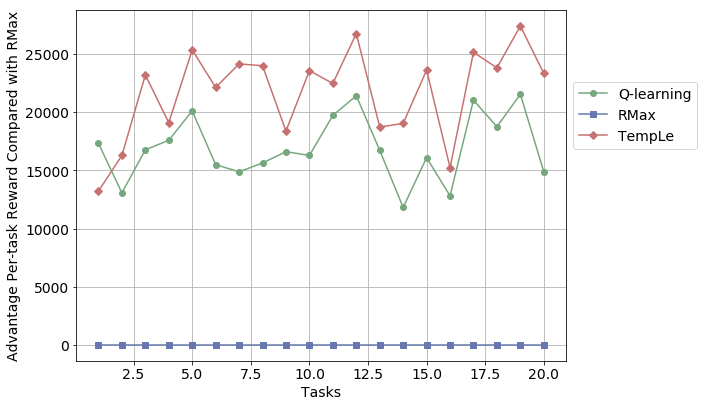

In [69]:
# maze plot: advantage per-task reward compared against RMax
mtask_plot_rmax(n=episodes, filepath="results/", filedir="lifelong-maze_h-4_w-4",
                models=models, samples=n_samples, use_smooth=False)

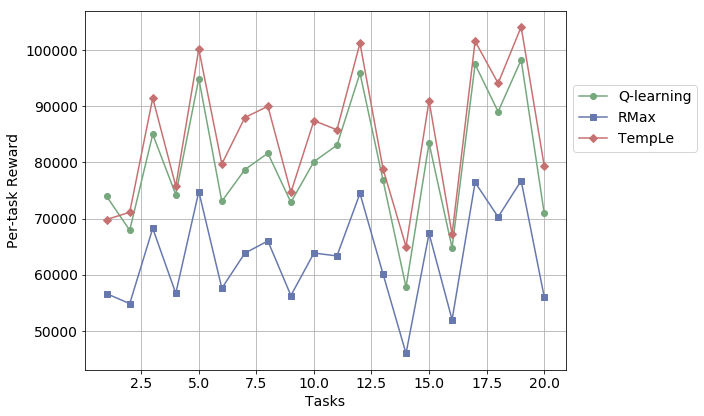

In [70]:
# maze plot: per-task reward
mtask_plot(n=episodes, filepath="results/", filedir="lifelong-maze_h-4_w-4",
                models=models, samples=n_samples, use_smooth=False)

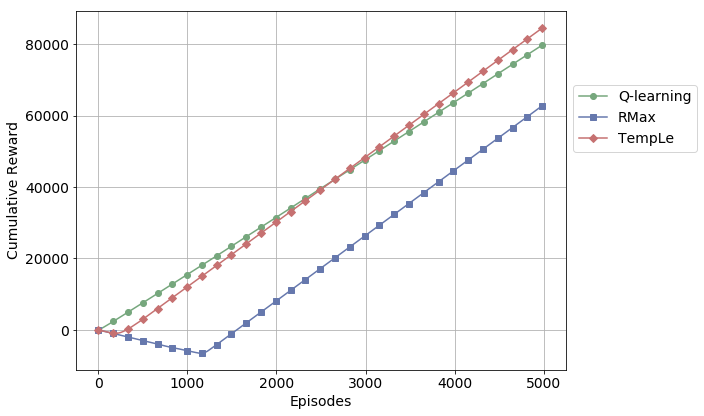

In [71]:
# maze plot: average accumulative rewards
acc_plot(n=episodes, filepath="results/", filedir="lifelong-maze_h-4_w-4",
                models=models, samples=n_samples, use_smooth=False)

In [85]:
#################
### GRID TEST ###
#################

In [88]:
# GRID PARAMETERS
height, width = 4,4
n_samples = 20
n_mdps = 2
step_cost = 0.2
gamma=0.95
thres = 500
s_thres = 100
t1 = 5
tau = 0.24
m_gap = 0.6
episodes = 5000
steps = 30
models=["Q-learning", "RMax", "TempLe", "FMRL"]

In [89]:
# GRID EXPERIMENT
goals = []
    
for i in range(n_mdps):
    random_goal = (random.randint(1, width), random.randint(1, height))
    goals.append(random_goal)
print("goals:",goals)

mdps = []
for i in range(n_samples):
    mdp = GridWorldMDP(width=width, height=height, goal_locs=[random.choice(goals)], is_goal_terminal=False,
                          lava_locs=[(int(width/2),int(height/2))], gamma=gamma, slip_prob=0.4, 
                          step_cost=step_cost, rand_init=True)
    mdps.append(mdp)
    
mdp_list = MDPList(mdps)
    
ql_agent = QLearningAgent(actions=mdp_list.get_actions(), gamma=gamma)

rmax_agent = TabularRMaxAgent(states=mdp.states, state_map=mdp.state_map, actions=mdp.get_actions(), 
                        s_a_threshold=thres, greedy=False, gamma=gamma)
multi_agent = MultiTaskRMaxAgent(states=mdp.states, state_map=mdp.state_map, actions=mdp.get_actions(),
                                 thres_sm=s_thres, thres_lg=thres, t1=t1+1, model_gap=m_gap, greedy=False, gamma=gamma)
pattern_agent = PatternLearningAgent(states=mdp.states, state_map=mdp.state_map, actions=mdp.get_actions(),
                                 thres_sm=s_thres, thres_lg=thres, pattern_gap=tau, greedy=False, gamma=gamma,
                                 with_grouping=True, t1=t1, model_gap=m_gap)

# run test
run_agents_seq([ql_agent, rmax_agent, pattern_agent, multi_agent], mdp_list, samples=n_samples,
                    episodes=episodes, steps=steps, reset_at_terminal=True, open_plot=True)

goals: [(4, 4), (3, 3)]
renew the single agent
Running experiment: 
(MDP)
	lifelong-gridworld_h-4_w-4
(Agents)
	Q-learning,0
	RMax,1
	TempLe,2
	FMRL,3
(Params)
	samples : 20
	episodes : 5000
	steps : 30
	track_disc_reward : False

Q-learning is learning.
  Sample 1 of 20.
goal
[(4, 4)]
10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370.

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..[1. 0.]
identified as 0
known [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..140

170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850..1860..1870..1880..1890..1900..1910..1920..1930..1940..1950..1960..197

150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850..1860..1870..1880..1890..1900..1910..1920..1930..1940..1950.

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850..1860..1870..1880..1890..1900..1910..1920..1930..1940..1950..1960..1970..1980..1990..2000..2010..202

220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850..1860..1870..1880..1890..1900..1910..1920..1930..1940..1950..1960..1970..1980..1990..2000..2010

230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850..1860..1870..1880..1890..1900..1910..1920..1930..1940..1950..1960..1970..1980..1990..2000..2010..202

230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850..1860..1870..1880..1890..1900..1910..1920..1930..1940..1950..1960..1970..1980..1990..2000..2010..202

260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850..1860..1870..1880..1890..1900..1910..1920..1930..1940..1950..1960..1970..1980..1990..2000..2010..2020..2030..2040..

270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850..1860..1870..1880..1890..1900..1910..1920..1930..1940..1950..1960..1970..1980..1990..2000..2010..2020..2030..2040..2050.

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

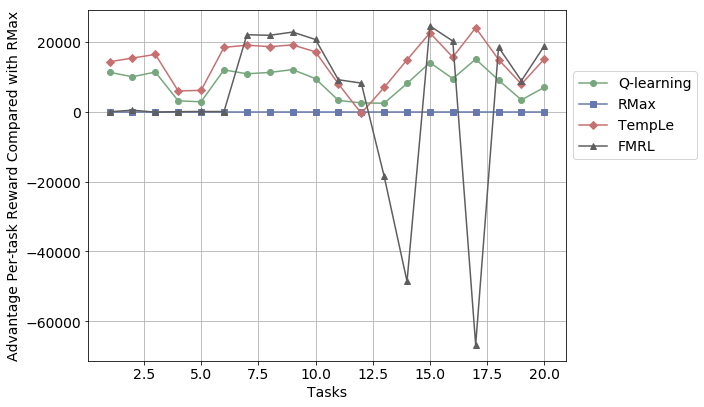

In [90]:
# grid plot: advantage per-task reward compared against RMax
mtask_plot_rmax(n=episodes, filepath="results/", filedir="lifelong-gridworld_h-4_w-4",
                models=models, samples=n_samples, use_smooth=False)

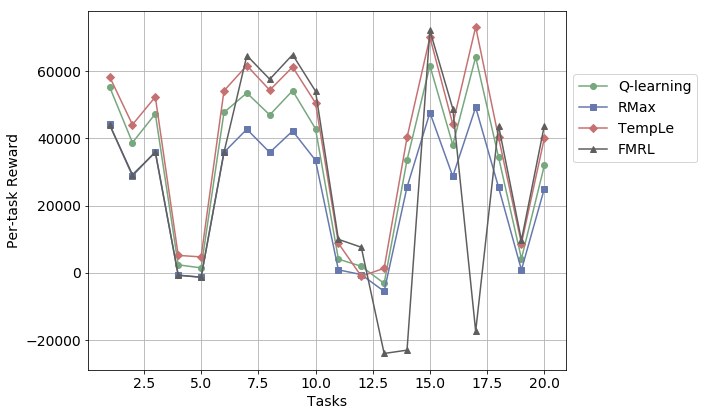

In [91]:
# grid plot: per-task reward
mtask_plot(n=episodes, filepath="results/", filedir="lifelong-gridworld_h-4_w-4",
                models=models, samples=n_samples, use_smooth=False)

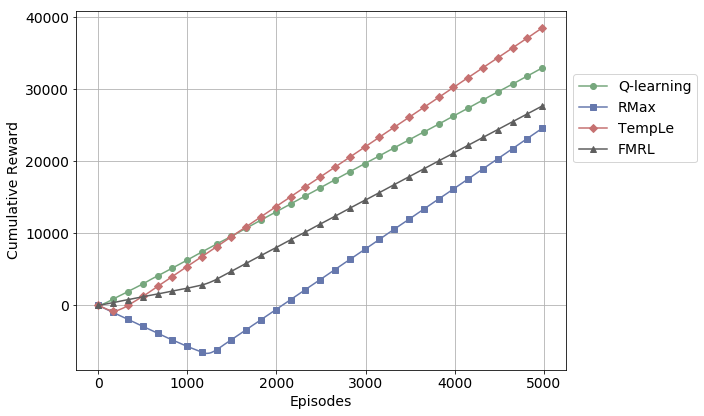

In [94]:
# grid plot: average accumulative rewards
acc_plot(n=episodes, filepath="results/", filedir="lifelong-gridworld_h-4_w-4",
                models=models, samples=n_samples, use_smooth=False)

In [4]:
#########################
### VARYING SIZE TEST ###
#########################

In [7]:
# VARYING SIZE PARAMETERS
samples_per_size = 5
n_sizes = 4
forms = [0,0.2,0.4]
smallest_size = 3
step_cost = 0.2
gamma=0.95
thres = 500
s_thres = 50
tau = 0.15
episodes = 5000
steps = 30
models=["Q-learning", "RMax", "TempLe"]

In [10]:
# VARYING SIZE EXPERIMENT
mdps = []
for k in range(n_sizes):
    for s in range(samples_per_size):
        landforms = []
        size = smallest_size + k
        for i in range(size*size):
            landforms.append(random.choice(forms)) 
        mdp = MazeMDP(width=size, height=size, landforms=landforms, 
                      goal_locs=[(size, size)], rand_init=True, is_goal_terminal=False,
                           lava_locs=[], gamma=gamma, step_cost=step_cost)
        mdps.append(mdp)

mdp_list = MDPList(mdps, is_var=True)

ql_agent = QLearningAgent(actions=mdp_list.get_actions(), gamma=gamma)

rmax_agent = TabularRMaxAgent(states=mdp.states, state_map=mdp.state_map, actions=mdp.get_actions(), 
                        s_a_threshold=thres, greedy=False, gamma=gamma)
pattern_agent = PatternLearningAgent(states=mdp.states, state_map=mdp.state_map, actions=mdp.get_actions(),
                                 thres_sm=s_thres, thres_lg=thres, pattern_gap=tau, greedy=False, gamma=gamma)
# run test
n_samples = samples_per_size * n_sizes
run_agents_seq_var([ql_agent, rmax_agent, pattern_agent], mdp_list, samples=n_samples,
                    episodes=episodes, steps=steps, reset_at_terminal=True, open_plot=False)

Running experiment: 
(MDP)
	lifelong-varsize
(Agents)
	Q-learning,0
	RMax,1
	TempLe,2
(Params)
	samples : 20
	episodes : 5000
	steps : 30
	track_disc_reward : False

Q-learning is learning.
  Sample 1 of 20.
goal
[(3, 3)]
10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

0.46838759079248726
0.2203820020745099
0.39085652839590157
0.3156044615483303
1.0697014457653917
1.0888722060522729
0.53471843770007
0.8512957793842325
1.035555269890971
0.5062186641747136
0.8027089001731254
0.30353297448561845
1.0022470553061993
0.25810039939096985
0.49080798548179383
1.0964430147278363
0.3904519876345528
1.037395040373601
1.2603358867243757
1.4929074516678384
0.970163315714321
1.1612786374264377
0.23118739082867823
0.2552322663651608
0.8589642516075857
0.19396788050166602
1.0337370058725164
0.6056516427682919
0.33165144486243886
1.2819698647183069
0.7059979775995886
0.7585454560354135
0.956214497122141
10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990..1000..1010..1020..1030..1040..1050..1060..1070..1080..1090..1100..1110..1120..1130..1140..1150..1160..1170..1180..1190..1200..1210..1220..1230..1240..1250..1260..1270..1280..1290..1300..1310..1320..1330..1340..1350..1360..1370..1380..1390..1400..1410..1420..1430..1440..1450..1460..1470..1480..1490..1500..1510..1520..1530..1540..1550..1560..1570..1580..1590..1600..1610..1620..1630..1640..1650..1660..1670..1680..1690..1700..1710..1720..1730..1740..1750..1760..1770..1780..1790..1800..1810..1820..1830..1840..1850

	Q-learning: 73415.4 (conf_interv: 6574.01 )
	RMax: 48791.05 (conf_interv: 10703.02 )
	TempLe: 78458.15 (conf_interv: 6474.0 )



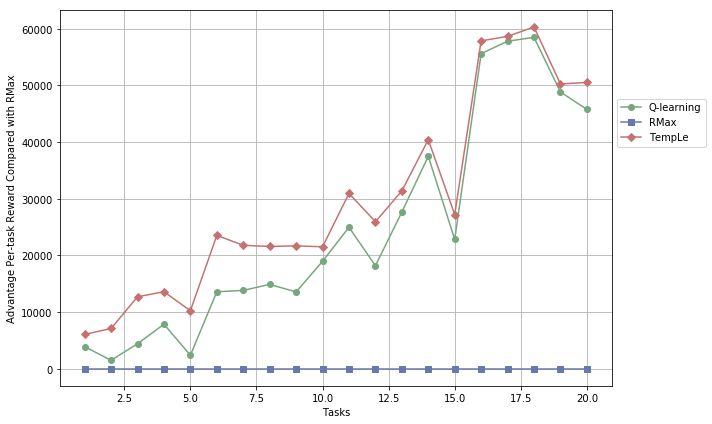

In [14]:
# var size plot: advantage per-task reward compared against RMax
mtask_plot_rmax(n=episodes, filepath="results/", filedir="lifelong-varsize",
                models=models, samples=n_samples, use_smooth=False)

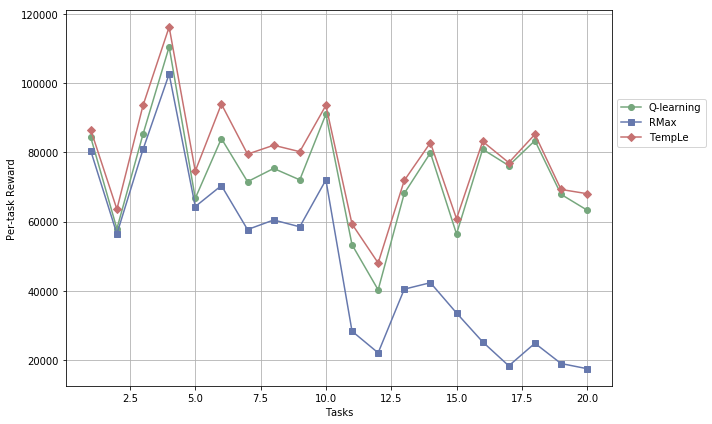

In [12]:
# var size plot: per-task reward
mtask_plot(n=episodes, filepath="results/", filedir="lifelong-varsize",
                models=models, samples=n_samples, use_smooth=False)

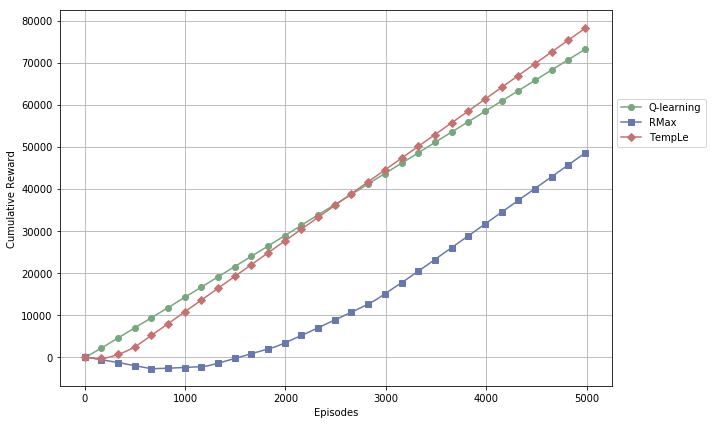

In [13]:
# grid plot: average accumulative rewards
acc_plot(n=episodes, filepath="results/", filedir="lifelong-varsize",
                models=models, samples=n_samples, use_smooth=False)